In [1]:
# Dependency management
# --------------------------------------------------------
import sys
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root / "scripts"))
from setup_environment import setup_paths
project_root = setup_paths()

# Data manipulation
# --------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl
import math
import time
import joblib

# Visualizations
# --------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import altair as alt
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from bokeh.plotting import figure, show
import seaborn.objects as so
import plotly.express as px

# Custom scripts
# ---------------------------------------------------------
from data_processing.cleaner import (cleaning, 
                                     compare_and_drop_duplicates)
from feature_selection.selector import (select_vars, 
                                       choose_variable_to_drop, 
                                       corr_comparison, 
                                       mutual_information)

# Correlation
# ---------------------------------------------------------
from dython.nominal import associations

# Dimension Reduction
# ---------------------------------------------------------
import umap

# Preprocessing
# ---------------------------------------------------------
from sklearn.preprocessing import (MinMaxScaler, 
                                   RobustScaler, 
                                   QuantileTransformer, 
                                   OrdinalEncoder,
                                  LabelEncoder)
from sklearn import preprocessing
from category_encoders import BinaryEncoder

# Random Forest
# ---------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier

# Support Vector Machine Classifier
# ---------------------------------------------------------
from sklearn.svm import SVC

# XGBoost
# ---------------------------------------------------------
import xgboost as xgb
from xgboost import XGBClassifier

# Model selection
# ---------------------------------------------------------
from sklearn.model_selection import (train_test_split, 
                                     RepeatedStratifiedKFold, 
                                     StratifiedKFold, 
                                     cross_val_score)

# Metrics
# ---------------------------------------------------------
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix,
                             make_scorer,
                             classification_report,
                             ConfusionMatrixDisplay
                             )

# Hyperparameter optimization
# ----------------------------------------------------------
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# GNN
# ---------------------------------------------------------
import torch
from torch_geometric.data import HeteroData


# Other
# ---------------------------------------------------------
from collections import Counter
from tqdm import tqdm
import random
random.seed(2024)
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [2]:
# Load saved merged_df.csv
merged_df = pd.read_csv(f"{project_root}/data/interim/merged_df.csv")
print(merged_df.shape)
print()
print(merged_df.columns)

(328116, 31)

Index(['#chrom', 'chromStart', 'chromEnd', 'name', 'score', 'reserved',
       'blockSizes', 'clinSign', 'reviewStatus', 'type', 'molConseq',
       'testedInGtr', 'phenotypeList', 'origin', 'cytogenetic', 'vcfDesc',
       '_clinSignCode', 'simplified_hgvs', 'Gene', 'ClinClass',
       'Classification', 'bin_class', 'classification_oncokb', 'gen',
       'gen_label', 'string_per_umap_cluster',
       'string_per_umap_cluster_description', 'string_total_clustering',
       'string_total_clustering_description', 'x_position', 'y_position'],
      dtype='object')


In [3]:
# Final columns to drop
final_drop_check = ["geneId", "_originCode", "_allTypeCode", "ClinInfo", 
                     "reserved", "numSubmit", "_variantId", "real_id", 
                     "origName", "rcvAcc", "snpId", "Start", "End", "phenotype", 
                    "_mouseOver", "Classification", "_clinSignCode", 
                    'clinSign', "ClinClass", "chromStart", "chromEnd", "gen", 
                    "vcfDesc", "testedInGtr", "string_per_umap_cluster", "string_total_clustering"]

for i in final_drop_check:
    if i in merged_df.columns:
        merged_df = merged_df.drop([i], axis=1)

merged_df.columns

Index(['#chrom', 'name', 'score', 'blockSizes', 'reviewStatus', 'type',
       'molConseq', 'phenotypeList', 'origin', 'cytogenetic',
       'simplified_hgvs', 'Gene', 'bin_class', 'classification_oncokb',
       'gen_label', 'string_per_umap_cluster_description',
       'string_total_clustering_description', 'x_position', 'y_position'],
      dtype='object')

# Nodes

In [4]:
data = merged_df.copy()

# Step 1: Create Gene Nodes
genes = data['Gene'].unique()  # Get unique genes

gene_nodes = []
for gene in genes:
    gene_data = data[data['Gene'] == gene].iloc[0]  # Take the first occurrence of the gene to extract features
    gene_node = {
        'name': gene,
        'gen_label': gene_data['gen_label'],  # Oncogenic or tumor suppressor label
        'x_position': gene_data['x_position'],  # Latent space position X
        'y_position': gene_data['y_position'],  # Latent space position Y
        'clustering_description': gene_data['string_total_clustering_description']  # Clustering description
    }
    gene_nodes.append(gene_node)

# Step 2: Create Variant Nodes
variant_nodes = []
for index, row in data.iterrows():
    variant_node = {
        'gene': row['Gene'],                    # Associated gene for the variant
        'type': row['type'],                    # Variant type (e.g., deletion, duplication)
        'molConseq': row['molConseq'],          # Molecular consequence (e.g., nonsense, frameshift)
        'blockSizes': row['blockSizes'],        # Variant size or block size
        'score': row['score'],                  # Score associated with the variant
        'reviewStatus': row['reviewStatus'],    # Review status (e.g., reviewed, not classified)
        'bin_class': row['bin_class']           # Binary classification (pathogenic or not)
    }
    variant_nodes.append(variant_node)

# Output examples of the created nodes
gene_nodes[:5], variant_nodes[:5]

([{'name': 'aip',
   'gen_label': 9,
   'x_position': 0.2159479553903345,
   'y_position': 0.3324501032346869,
   'clustering_description': 'DNA repair pathways, full network, and HDR through Homologous Recombination (HRR) '},
  {'name': 'akt1',
   'gen_label': 9,
   'x_position': 0.4588475836431226,
   'y_position': 0.4470406056434962,
   'clustering_description': 'DNA repair pathways, full network, and HDR through Homologous Recombination (HRR) '},
  {'name': 'alk',
   'gen_label': 18,
   'x_position': 0.4642007434944238,
   'y_position': 0.5541982105987613,
   'clustering_description': 'DNA repair pathways, full network, and HDR through Homologous Recombination (HRR) '},
  {'name': 'antxr1',
   'gen_label': 5,
   'x_position': 0.6950557620817844,
   'y_position': 0.7784239504473504,
   'clustering_description': 'Uptake and function of anthrax toxins Mixed, incl. Anthrax disease, and SH3-binding 5'},
  {'name': 'antxr2',
   'gen_label': 12,
   'x_position': 0.7566171003717472,
   'y_

In [5]:
print("gene_nodes", len(gene_nodes))
print("variant_nodes", len(variant_nodes))

gene_nodes 136
variant_nodes 328116


# Edges

In [6]:
# Step 2: Create Gene-Variant Edges

gene_variant_edges = []

for index, row in data.iterrows():
    gene = row['Gene']
    variant_type = row['type']
    
    edge = {
        'gene': gene,  # Source: Gene node
        'variant': variant_type,  # Target: Variant node (use 'type' as the variant representation)
        'blockSizes': row['blockSizes'],  # Optional edge weight
        'cytogenetic_region': row['cytogenetic'],  # Cytogenetic region information
    }
    
    gene_variant_edges.append(edge)

# Optional Step: Create Gene-Gene Edges based on Cytogenetic region or Latent space proximity
gene_gene_edges = []
cytogenetic_regions = data['cytogenetic'].unique()

for region in cytogenetic_regions:
    # Find all genes in the same cytogenetic region
    genes_in_region = data[data['cytogenetic'] == region]['Gene'].unique()
    
    # Create edges between all pairs of genes in this region
    for i, gene1 in enumerate(genes_in_region):
        for gene2 in genes_in_region[i + 1:]:
            edge = {
                'gene1': gene1,  # Source: Gene node 1
                'gene2': gene2,  # Target: Gene node 2
                'region': region,  # Cytogenetic region shared between both genes
            }
            gene_gene_edges.append(edge)

# Output examples of created edges
gene_variant_edges[:5], gene_gene_edges[:5]

([{'gene': 'aip',
   'variant': 'single nucleotide variant',
   'blockSizes': 1,
   'cytogenetic_region': '11q13.2'},
  {'gene': 'aip',
   'variant': 'single nucleotide variant',
   'blockSizes': 1,
   'cytogenetic_region': '11q13.2'},
  {'gene': 'aip',
   'variant': 'single nucleotide variant',
   'blockSizes': 1,
   'cytogenetic_region': '11q13.2'},
  {'gene': 'aip',
   'variant': 'single nucleotide variant',
   'blockSizes': 1,
   'cytogenetic_region': '11q13.2'},
  {'gene': 'aip',
   'variant': 'single nucleotide variant',
   'blockSizes': 1,
   'cytogenetic_region': '11q13.2'}],
 [{'gene1': 'akt1', 'gene2': 'xrcc3', 'region': '14q32.33'},
  {'gene1': 'ddb2', 'gene2': 'ext2', 'region': '11p11.2'},
  {'gene1': 'epcam', 'gene2': 'msh2', 'region': '2p21'},
  {'gene1': 'fanca', 'gene2': 'mc1r', 'region': '16q24.3'},
  {'gene1': 'fancc', 'gene2': 'ptch1', 'region': '9q22.32'}])

In [7]:
print("gene_variant_edges", len(gene_variant_edges))
print("gene_gene_edges", len(gene_gene_edges))

gene_variant_edges 328116
gene_gene_edges 20


# Graph representation: Heterograph

In [8]:
# Step 3: Graph Representation using PyTorch Geometric
# Create HeteroData object
data = HeteroData()

# Add Gene nodes
gene_x = []
gene_labels = []
for gene in gene_nodes:
    gene_x.append([gene['x_position'], gene['y_position']])  # Latent positions as node features
    gene_labels.append(gene['gen_label'])  # Gene label (oncogenic/tumor suppressor)

data['gene'].x = torch.tensor(gene_x, dtype=torch.float)  # Node features for genes
data['gene'].y = torch.tensor(gene_labels, dtype=torch.long)  # Labels for gene nodes

In [9]:
# Add Variant nodes
variant_x = []
variant_labels = []
for variant in variant_nodes:
    variant_x.append([variant['blockSizes']])  # Variant features (e.g., blockSizes)
    variant_labels.append(variant['bin_class'])  # Pathogenicity label (binary classification)

data['variant'].x = torch.tensor(variant_x, dtype=torch.float)  # Node features for variants
data['variant'].y = torch.tensor(variant_labels, dtype=torch.long)  # Labels for variant nodes

# Optimized

In [10]:
# Step 3: Optimized Graph Representation

# Create mapping for gene names to their indices for faster lookups
gene_idx_map = {gene['name']: idx for idx, gene in enumerate(gene_nodes)}

# Create mapping for variant nodes based on gene name and variant type
variant_idx_map = {(variant['gene'], variant['type']): idx for idx, variant in enumerate(variant_nodes)}

# Create Gene-Variant edges using the pre-built index maps
gene_to_variant_edge_index = [[], []]

for edge in gene_variant_edges:
    gene_idx = gene_idx_map.get(edge['gene'])
    variant_idx = variant_idx_map.get((edge['gene'], edge['variant']))
    
    if gene_idx is not None and variant_idx is not None:
        gene_to_variant_edge_index[0].append(gene_idx)
        gene_to_variant_edge_index[1].append(variant_idx)

# Convert edge index to tensor
data['gene', 'interacts_with', 'variant'].edge_index = torch.tensor(gene_to_variant_edge_index, dtype=torch.long)

# Optional: Optimize Gene-Gene edge creation similarly
gene_to_gene_edge_index = [[], []]

for edge in gene_gene_edges:
    gene1_idx = gene_idx_map.get(edge['gene1'])
    gene2_idx = gene_idx_map.get(edge['gene2'])
    
    if gene1_idx is not None and gene2_idx is not None:
        # Add bidirectional edges
        gene_to_gene_edge_index[0].append(gene1_idx)
        gene_to_gene_edge_index[1].append(gene2_idx)
        gene_to_gene_edge_index[0].append(gene2_idx)
        gene_to_gene_edge_index[1].append(gene1_idx)

# Convert edge index to tensor
data['gene', 'connected_to', 'gene'].edge_index = torch.tensor(gene_to_gene_edge_index, dtype=torch.long)

In [11]:
print(data)

HeteroData(
  gene={
    x=[136, 2],
    y=[136],
  },
  variant={
    x=[328116, 1],
    y=[328116],
  },
  (gene, interacts_with, variant)={ edge_index=[2, 328116] },
  (gene, connected_to, gene)={ edge_index=[2, 40] }
)


```python
HeteroData(
  gene={
    x=[136, 2],   # 136 genes, each with 2 features (x_position, y_position)
    y=[136],      # 136 gene labels (e.g., oncogenic/tumor suppressor)
  },
  variant={
    x=[328116, 1],  # 328,116 variants, each with 1 feature (e.g., blockSizes)
    y=[328116],     # 328,116 binary labels (pathogenic or non-pathogenic)
  },
  (gene, interacts_with, variant)={ edge_index=[2, 328116] },   # 328,116 edges between genes and variants
  (gene, connected_to, gene)={ edge_index=[2, 40] }  # 40 gene-gene connections (bidirectional edges)
)


gene_nodes 136
variant_nodes 328116
gene_variant_edges 328116
gene_gene_edges 20

```

In [12]:
data.metadata()

(['gene', 'variant'],
 [('gene', 'interacts_with', 'variant'), ('gene', 'connected_to', 'gene')])

# Save HeteroData

In [13]:
from torch_geometric.data import HeteroData
import torch
import os

# To save the data
def save_hetero_data(data: HeteroData, path: str):
    """
    Save a HeteroData object to disk.
    
    Args:
        data (HeteroData): The heterogeneous graph data to save
        path (str): Path where to save the data
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Save the data
    torch.save(data, path)
    print(f"Data saved to {path}")

# To load the data
def load_hetero_data(path: str) -> HeteroData:
    """
    Load a HeteroData object from disk.
    
    Args:
        path (str): Path to the saved data file
        
    Returns:
        HeteroData: The loaded heterogeneous graph data
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"No data file found at {path}")
    
    data = torch.load(path)
    print(f"Data loaded from {path}")
    return data

# Example usage:
# Saving
data_path = "data/processed/hetero_graph.pt"
save_hetero_data(data, data_path)

# Loading
loaded_data = load_hetero_data(data_path)

Data saved to data/processed/hetero_graph.pt
Data loaded from data/processed/hetero_graph.pt


# GraphSAGE Multiheaded Attetion

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv, HeteroConv, Linear
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
from torch.optim import Adam
from torch.nn import Linear
from sklearn.metrics import f1_score
import optuna
from optuna.trial import Trial
from torch_geometric.data import HeteroData

# Determine the number of classes for genes and variants
num_gene_classes = len(torch.unique(data['gene'].y))
num_variant_classes = len(torch.unique(data['variant'].y))

print(f"Number of gene classes: {num_gene_classes}")
print(f"Number of variant classes: {num_variant_classes}")

class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.attentions = nn.ModuleList([
            nn.Linear(in_channels, out_channels) for _ in range(num_heads)
        ])
        self.out_proj = nn.Linear(out_channels * num_heads, out_channels)

    def forward(self, x):
        x = torch.cat([att(x) for att in self.attentions], dim=-1)
        return self.out_proj(x)

# Define the model class as provided
class GraphSAGEWithAttention(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, num_heads, num_gene_classes, num_variant_classes, activation_fn):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.attentions = torch.nn.ModuleList()
        self.activation_fn = activation_fn

        # Initial convolution layer
        self.convs.append(HeteroConv({
            ('gene', 'interacts_with', 'variant'): SAGEConv((-1, -1), hidden_channels),
            ('gene', 'connected_to', 'gene'): SAGEConv((-1, -1), hidden_channels),
            ('variant', 'rev_interacts_with', 'gene'): SAGEConv((-1, -1), hidden_channels)
        }))
        self.attentions.append(MultiHeadAttention(hidden_channels, hidden_channels, num_heads))

        # Hidden convolution layers
        for _ in range(num_layers - 2):
            self.convs.append(HeteroConv({
                ('gene', 'interacts_with', 'variant'): SAGEConv((-1, -1), hidden_channels),
                ('gene', 'connected_to', 'gene'): SAGEConv((-1, -1), hidden_channels),
                ('variant', 'rev_interacts_with', 'gene'): SAGEConv((-1, -1), hidden_channels)
            }))
            self.attentions.append(MultiHeadAttention(hidden_channels, hidden_channels, num_heads))

        # Final convolution layer
        self.convs.append(HeteroConv({
            ('gene', 'interacts_with', 'variant'): SAGEConv((-1, -1), out_channels),
            ('gene', 'connected_to', 'gene'): SAGEConv((-1, -1), out_channels),
            ('variant', 'rev_interacts_with', 'gene'): SAGEConv((-1, -1), out_channels)
        }))
        self.attentions.append(MultiHeadAttention(out_channels, out_channels, num_heads))

        self.gene_lin = Linear(out_channels, num_gene_classes)
        self.variant_lin = Linear(out_channels, num_variant_classes)

    def forward(self, x_dict, edge_index_dict):
        for conv, attention in zip(self.convs, self.attentions):
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: attention(self.activation_fn(x)) for key, x in x_dict.items()}

        return {
            'gene': self.gene_lin(x_dict['gene']),
            'variant': self.variant_lin(x_dict['variant'])
        }


#config = {
#    "hidden_channels": tune.choice([64]),
#    "out_channels": tune.choice([32, 64]),
#    "num_layers": tune.choice([2, 3, 4, 5]),
#    "num_heads": tune.choice([2, 4]),
#    "lr": tune.loguniform(1e-4, 1e-2),
#    "weight_decay": tune.loguniform(1e-5, 1e-3),
#    "dropout_rate": tune.uniform(0.1, 0.5),
#    "activation_fn": tune.choice(["relu", "gelu", "leaky_relu"]),
#}
    

# Define the objective function for optuna
def objective(trial: Trial, data: HeteroData):
    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Hyperparameter search space
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128, step=32)
    out_channels = trial.suggest_int("out_channels", 32, 128, step=32)
    num_layers = trial.suggest_int("num_layers", 2, 4)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout", 0.0, 0.5)  # Added dropout with a reasonable range
    
    # Choose activation function
    activation_name = trial.suggest_categorical("activation", ["gelu", "leaky_relu"])
    activation_fn = F.gelu if activation_name == "gelu" else F.leaky_relu

    # Initialize the model, optimizer, and loss function
    model = GraphSAGEWithAttention(hidden_channels, out_channels, num_layers, num_heads, 
                                   num_gene_classes=num_gene_classes, 
                                   num_variant_classes=num_variant_classes,
                                   activation_fn=activation_fn).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(10):  # Short epochs for optimization speed
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        loss = F.cross_entropy(out['gene'], data['gene'].y) + F.cross_entropy(out['variant'], data['variant'].y)
        loss.backward()
        optimizer.step()

    # Evaluation with F1 score on validation data
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        gene_pred = out['gene'].argmax(dim=1)
        variant_pred = out['variant'].argmax(dim=1)

        # Calculate F1 scores
        gene_f1 = f1_score(data['gene'].y.cpu(), gene_pred.cpu(), average="macro")
        print(gene_f1)
        variant_f1 = f1_score(data['variant'].y.cpu(), variant_pred.cpu(), average="macro")
        print(variant_f1)
        f1 = (gene_f1 + variant_f1) / 2

    return f1

# Set up and execute the optuna study
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, data), n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2024-10-25 20:54:55,788] A new study created in memory with name: no-name-0b0903be-4a64-4b70-be5f-cbadfc8d5fac


Number of gene classes: 20
Number of variant classes: 2


[I 2024-10-25 20:57:11,289] Trial 0 finished with value: 0.24115569222129823 and parameters: {'hidden_channels': 64, 'out_channels': 96, 'num_layers': 3, 'num_heads': 2, 'learning_rate': 0.00031143723246377226, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.24115569222129823.
[I 2024-10-25 20:59:01,821] Trial 1 finished with value: 0.2939507735858973 and parameters: {'hidden_channels': 32, 'out_channels': 96, 'num_layers': 2, 'num_heads': 4, 'learning_rate': 0.005981493620071629, 'activation': 'gelu'}. Best is trial 1 with value: 0.2939507735858973.
[I 2024-10-25 21:05:08,553] Trial 2 finished with value: 0.24115569222129823 and parameters: {'hidden_channels': 64, 'out_channels': 128, 'num_layers': 4, 'num_heads': 4, 'learning_rate': 0.0006158007801911105, 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.2939507735858973.
[I 2024-10-25 21:06:03,472] Trial 3 finished with value: 0.24115569222129823 and parameters: {'hidden_channels': 32, 'out_channels': 96, 'num_la

# Embedding UMAP

In [ ]:
# Hyperparameters
hidden_channels = 128
out_channels = 64
num_layers = 3
num_heads = 4
learning_rate = 0.001
num_epochs = 100
batch_size = 32  # If you're using full-batch training, this will be ignored

# Determine the number of classes for genes and variants
num_gene_classes = len(torch.unique(data['gene'].y))
num_variant_classes = len(torch.unique(data['variant'].y))

print(f"Number of gene classes: {num_gene_classes}")
print(f"Number of variant classes: {num_variant_classes}")

# Create the model with the correct number of output classes
model = GraphSAGEWithAttention(hidden_channels, out_channels, num_layers, num_heads, num_gene_classes, num_variant_classes)

# ... (train_val_split, train_epoch, validate, and train_and_validate functions remain the same)

# Split the data into train and validation sets
data = train_val_split(data)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train and validate the model
best_model = train_and_validate(model, data, optimizer, criterion, num_epochs)

# Load the best model
model.load_state_dict(best_model)

print("Training and validation completed. The model with the best validation loss has been saved.")

# For inference on new data
def inference(model, new_data):
    model.eval()
    with torch.no_grad():
        out = model(new_data.x_dict, new_data.edge_index_dict)
    return out

# Example of using the trained model for inference
# new_data = ... # Prepare your new data
# predictions = inference(model, new_data)

In [92]:
def get_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        # Forward pass through all layers except the final classification
        x_dict = data.x_dict
        edge_index_dict = data.edge_index_dict
        
        # Get embeddings before final classification layer
        for conv, attention in zip(model.convs, model.attentions):
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: attention(F.relu(x)) for key, x in x_dict.items()}
        
        # Return embeddings for both node types
        return {
            'gene_embeddings': x_dict['gene'].cpu().numpy(),
            'variant_embeddings': x_dict['variant'].cpu().numpy()
        }

# Usage example:
embeddings = get_embeddings(model, data)
variant_embeddings = embeddings['variant_embeddings']
gene_embeddings = embeddings['gene_embeddings']

In [94]:
variant_embeddings.shape

(328116, 64)

In [95]:
gene_embeddings.shape

(136, 64)

In [96]:
len(merged_df["bin_class"])

328116

In [105]:
temp = pd.DataFrame(variant_embeddings)
temp = temp.sample(n=1000, random_state=2024)
temp

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
190999,-0.153794,-0.072410,-0.154319,0.053987,-0.076169,0.157506,-0.256178,0.025342,0.051852,0.061117,...,-0.074244,-0.002142,0.070283,0.102546,0.120940,-0.135901,0.085995,0.070193,-0.006450,0.076242
9316,-0.149907,-0.032813,-0.144135,0.029721,-0.026771,0.130631,-0.224828,0.003251,0.011762,0.071105,...,-0.051207,0.000336,0.044873,0.083529,0.109780,-0.105402,0.080260,0.040757,-0.010369,0.044516
311117,-0.147024,-0.053525,-0.152767,0.041993,-0.056459,0.145730,-0.241319,0.011592,0.047815,0.073964,...,-0.052115,-0.011020,0.059478,0.089930,0.105859,-0.114956,0.086431,0.053374,-0.016799,0.061094
162094,-0.159829,-0.005003,-0.149625,-0.002459,-0.008023,0.098057,-0.186727,-0.000990,-0.041893,0.068145,...,-0.032314,0.027028,0.019509,0.078667,0.113544,-0.086500,0.077419,0.017319,-0.002429,0.017316
193635,-0.147419,-0.043751,-0.143085,0.034372,-0.039239,0.138817,-0.231912,0.007814,0.021180,0.070984,...,-0.056368,-0.005829,0.051130,0.086065,0.109628,-0.111940,0.079973,0.046068,-0.012105,0.049984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38623,-0.170107,-0.052981,-0.162956,0.035983,-0.058032,0.147965,-0.246658,0.016369,0.053838,0.071614,...,-0.044569,0.004916,0.069907,0.091749,0.110279,-0.108404,0.108771,0.062611,-0.007980,0.073637
216257,-0.149908,-0.037703,-0.144551,0.032327,-0.032586,0.134486,-0.228701,0.005707,0.016299,0.070751,...,-0.053798,-0.001161,0.047953,0.085307,0.110538,-0.108868,0.080694,0.043548,-0.010668,0.047456
236682,-0.150062,-0.036251,-0.144542,0.031689,-0.030867,0.133352,-0.227642,0.005080,0.014993,0.070806,...,-0.053104,-0.000501,0.047083,0.084882,0.110418,-0.107922,0.080662,0.042770,-0.010509,0.046665
161348,-0.146522,-0.054566,-0.152734,0.042997,-0.057826,0.146412,-0.241986,0.012489,0.048261,0.073482,...,-0.053486,-0.011270,0.059461,0.090455,0.106339,-0.116443,0.085655,0.053974,-0.016590,0.061834


In [106]:
import umap
standard_embedding = umap.UMAP().fit_transform(temp)

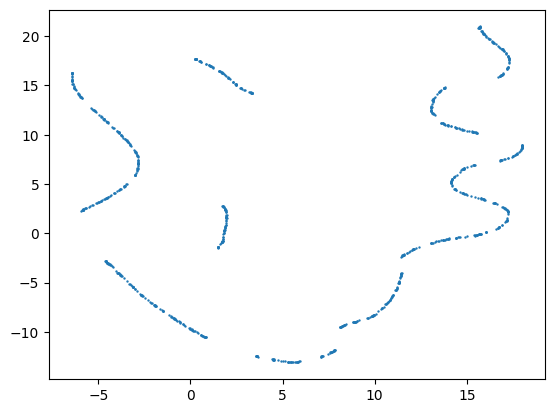

In [107]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.5);